# Feature Selection and Classification using Random Forest and HAC

In this notebook, the 24-hour flight data is used to conduct the classification.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from scipy.cluster.hierarchy import ward, fcluster

In [2]:
%run ../flight\ phase\ on\ dataset/db.py
df = db_to_pandas(filename='descriptors_24h.db')
df.head()

,flight_id,flight_start,flight_end,flight_duration,airline,icao,duration_descent,avg_speed_descent,std_speed_descent,avg_vertrate_speed_descent,...,duration_climb,avg_speed_climb,std_speed_climb,avg_vertrate_speed_climb,std_vertrate_speed_climb,delta_h_climb,max_spd_climb,min_spd_climb,max_vertrate_speed_climb,min_vertrate_speed_climb
0,1,1.597683e+09,1.597689e+09,6410.0,Air Arabia Maroc,0200f9,3170.0,162.752079,65.302395,-6.000625,...,710.0,236.873236,17.576272,8.693426,2.491583,5600.70,255.409919,215.001282,12.67968,3.57632
1,2,1.597644e+09,1.597654e+09,9350.0,Air Arabia Maroc,020108,2690.0,180.157112,65.826218,-5.694844,...,1370.0,211.879969,44.535401,7.598672,2.963807,10233.66,255.158519,79.909565,14.95552,2.27584
2,3,1.597657e+09,1.597668e+09,10370.0,Air Arabia Maroc,020108,1430.0,162.234516,56.032063,-7.989037,...,1190.0,173.766692,47.096655,9.958426,5.567489,10911.84,232.513322,55.227906,23.73376,-0.32512
3,4,1.597675e+09,1.597684e+09,9520.0,Air Arabia Maroc,020108,2860.0,176.455751,66.242427,-6.110245,...,4490.0,217.198070,46.342640,6.570305,2.971641,10927.08,256.325821,77.968397,15.28064,-0.32512
4,5,1.597688e+09,1.597698e+09,10190.0,Air Arabia Maroc,020108,2690.0,157.699108,61.944099,-8.355068,...,950.0,169.643762,44.787904,9.661801,3.812572,10888.98,213.196543,70.170237,19.18208,0.32512


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1560 entries, 0 to 1559
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   flight_id                   1560 non-null   int64  
 1   flight_start                1560 non-null   float64
 2   flight_end                  1560 non-null   float64
 3   flight_duration             1560 non-null   float64
 4   airline                     1518 non-null   object 
 5   icao                        1560 non-null   object 
 6   duration_descent            1560 non-null   float64
 7   avg_speed_descent           1560 non-null   float64
 8   std_speed_descent           1560 non-null   float64
 9   avg_vertrate_speed_descent  1560 non-null   float64
 10  std_vertrate_speed_descent  1560 non-null   float64
 11  delta_h_descent             1560 non-null   float64
 12  max_spd_descent             1560 non-null   float64
 13  min_spd_descent             1560 

<AxesSubplot:>

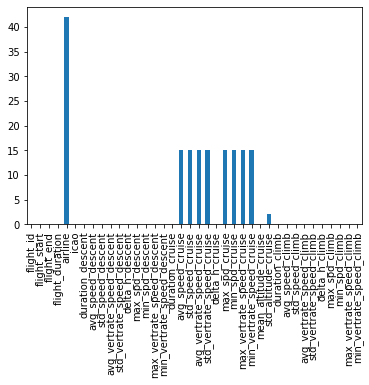

In [4]:
# The number of null values
df.isna().sum().plot(kind='bar')

In [5]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1503 entries, 0 to 1559
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   flight_id                   1503 non-null   int64  
 1   flight_start                1503 non-null   float64
 2   flight_end                  1503 non-null   float64
 3   flight_duration             1503 non-null   float64
 4   airline                     1503 non-null   object 
 5   icao                        1503 non-null   object 
 6   duration_descent            1503 non-null   float64
 7   avg_speed_descent           1503 non-null   float64
 8   std_speed_descent           1503 non-null   float64
 9   avg_vertrate_speed_descent  1503 non-null   float64
 10  std_vertrate_speed_descent  1503 non-null   float64
 11  delta_h_descent             1503 non-null   float64
 12  max_spd_descent             1503 non-null   float64
 13  min_spd_descent             1503 

In [6]:
df.drop(columns=['flight_start','flight_end','icao'],inplace=True)

In [7]:
df.head()

,flight_id,flight_duration,airline,duration_descent,avg_speed_descent,std_speed_descent,avg_vertrate_speed_descent,std_vertrate_speed_descent,delta_h_descent,max_spd_descent,...,duration_climb,avg_speed_climb,std_speed_climb,avg_vertrate_speed_climb,std_vertrate_speed_climb,delta_h_climb,max_spd_climb,min_spd_climb,max_vertrate_speed_climb,min_vertrate_speed_climb
0,1,6410.0,Air Arabia Maroc,3170.0,162.752079,65.302395,-6.000625,3.182320,723.90,260.851518,...,710.0,236.873236,17.576272,8.693426,2.491583,5600.70,255.409919,215.001282,12.67968,3.57632
1,2,9350.0,Air Arabia Maroc,2690.0,180.157112,65.826218,-5.694844,2.652992,-10683.24,260.546968,...,1370.0,211.879969,44.535401,7.598672,2.963807,10233.66,255.158519,79.909565,14.95552,2.27584
2,3,10370.0,Air Arabia Maroc,1430.0,162.234516,56.032063,-7.989037,5.072809,-11087.10,226.124327,...,1190.0,173.766692,47.096655,9.958426,5.567489,10911.84,232.513322,55.227906,23.73376,-0.32512
3,4,9520.0,Air Arabia Maroc,2860.0,176.455751,66.242427,-6.110245,3.371099,-11391.90,264.022063,...,4490.0,217.198070,46.342640,6.570305,2.971641,10927.08,256.325821,77.968397,15.28064,-0.32512
4,5,10190.0,Air Arabia Maroc,2690.0,157.699108,61.944099,-8.355068,5.436297,-11003.28,241.673724,...,950.0,169.643762,44.787904,9.661801,3.812572,10888.98,213.196543,70.170237,19.18208,0.32512


In [8]:
df['airline'].value_counts()

Eurowings                        161
American Airlines                150
Air France                       144
Wizz Air                         119
easyJet UK                        89
Lufthansa                         79
Alitalia                          74
British Airways                   53
Vueling Airlines                  53
United Airlines                   52
Delta Air Lines                   47
Spirit Airlines                   45
easyJet Europe                    36
Allegiant Air                     33
easyJet Switzerland               32
Aer Lingus                        27
Swiss International Air Lines     25
Brussels Airlines                 25
Ryanair                           23
Austrian Airlines                 23
Turkish Airlines                  21
Air Serbia                        18
Air Malta                         14
TAP Portugal                      14
Finnair                           13
Alaska Airlines, Inc.             13
Croatia Airlines                  11
V

In [9]:
df["airline"] = df["airline"].astype('category')
df["airline_cat"]=df["airline"].cat.codes
df_noairline = df.drop(columns=['airline'])
df_noairline.set_index('flight_id',inplace=True)
df_noairline.head()

,flight_duration,duration_descent,avg_speed_descent,std_speed_descent,avg_vertrate_speed_descent,std_vertrate_speed_descent,delta_h_descent,max_spd_descent,min_spd_descent,max_vertrate_speed_descent,...,avg_speed_climb,std_speed_climb,avg_vertrate_speed_climb,std_vertrate_speed_climb,delta_h_climb,max_spd_climb,min_spd_climb,max_vertrate_speed_climb,min_vertrate_speed_climb,airline_cat
flight_id,,,,,,,,,,,,,,,,,,,,,
1,6410.0,3170.0,162.752079,65.302395,-6.000625,3.182320,723.90,260.851518,67.664544,0.32512,...,236.873236,17.576272,8.693426,2.491583,5600.70,255.409919,215.001282,12.67968,3.57632,2
2,9350.0,2690.0,180.157112,65.826218,-5.694844,2.652992,-10683.24,260.546968,70.890682,0.32512,...,211.879969,44.535401,7.598672,2.963807,10233.66,255.158519,79.909565,14.95552,2.27584,2
3,10370.0,1430.0,162.234516,56.032063,-7.989037,5.072809,-11087.10,226.124327,62.538281,0.65024,...,173.766692,47.096655,9.958426,5.567489,10911.84,232.513322,55.227906,23.73376,-0.32512,2
4,9520.0,2860.0,176.455751,66.242427,-6.110245,3.371099,-11391.90,264.022063,70.630744,0.32512,...,217.198070,46.342640,6.570305,2.971641,10927.08,256.325821,77.968397,15.28064,-0.32512,2
5,10190.0,2690.0,157.699108,61.944099,-8.355068,5.436297,-11003.28,241.673724,57.112553,1.30048,...,169.643762,44.787904,9.661801,3.812572,10888.98,213.196543,70.170237,19.18208,0.32512,2


In [10]:
airlines_decoder = dict(enumerate(df["airline"].cat.categories))

In [11]:
df_noairline.describe()

,flight_duration,duration_descent,avg_speed_descent,std_speed_descent,avg_vertrate_speed_descent,std_vertrate_speed_descent,delta_h_descent,max_spd_descent,min_spd_descent,max_vertrate_speed_descent,...,avg_speed_climb,std_speed_climb,avg_vertrate_speed_climb,std_vertrate_speed_climb,delta_h_climb,max_spd_climb,min_spd_climb,max_vertrate_speed_climb,min_vertrate_speed_climb,airline_cat
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,...,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,6066.733200,2177.937458,165.757696,55.661682,-6.960707,3.886136,-9621.550419,237.082878,67.181270,0.243786,...,191.704994,43.536217,9.403641,4.228290,10600.814212,234.505092,75.898103,20.572330,0.616062,29.865602
std,2855.815225,1726.331942,14.031152,8.618562,1.121793,1.022967,3421.443725,19.578685,12.256837,0.828936,...,12.220314,6.422537,1.452275,0.701407,1317.789816,16.348559,12.255858,3.577249,1.793738,17.461177
min,2080.000000,870.000000,90.997767,7.593684,-11.877132,1.300288,-20794.980000,173.909466,12.009816,-4.551680,...,149.588608,1.116747,3.982720,1.461137,-601.980000,188.885735,0.000000,6.827520,-44.866560,0.000000
25%,4010.000000,1540.000000,156.391947,50.393308,-7.600098,3.184478,-11414.760000,226.886989,62.396351,0.000000,...,183.337361,39.360493,8.428887,3.771814,10256.520000,224.188414,72.821539,18.531840,0.000000,16.000000
50%,5520.000000,1790.000000,165.469126,55.678814,-6.815251,3.785717,-10873.740000,236.288335,66.049481,0.325120,...,190.715150,43.342096,9.311000,4.143643,10934.700000,233.520179,77.166600,20.157440,0.000000,29.000000
75%,7490.000000,2210.000000,174.612325,60.715311,-6.189960,4.494217,-9837.420000,246.286270,69.976676,0.325120,...,199.344474,47.614143,10.310972,4.624644,11361.420000,244.566591,80.728378,22.108160,0.975360,48.000000
max,28670.000000,22850.000000,229.323087,87.564446,-4.140130,8.375520,14577.060000,718.527086,221.157076,7.477760,...,238.074887,69.087429,15.022022,10.413252,12275.820000,531.917433,217.785479,92.008960,7.152640,56.000000


In [12]:
columns = df_noairline.columns
columns

Index(['flight_duration', 'duration_descent', 'avg_speed_descent',
       'std_speed_descent', 'avg_vertrate_speed_descent',
       'std_vertrate_speed_descent', 'delta_h_descent', 'max_spd_descent',
       'min_spd_descent', 'max_vertrate_speed_descent',
       'min_vertrate_speed_descent', 'duration_cruise', 'avg_speed_cruise',
       'std_speed_cruise', 'avg_vertrate_speed_cruise',
       'std_vertrate_speed_cruise', 'delta_h_cruise', 'max_spd_cruise',
       'min_spd_cruise', 'max_vertrate_speed_cruise',
       'min_vertrate_speed_cruise', 'mean_altitude_cruise',
       'std_altitude_cruise', 'duration_climb', 'avg_speed_climb',
       'std_speed_climb', 'avg_vertrate_speed_climb',
       'std_vertrate_speed_climb', 'delta_h_climb', 'max_spd_climb',
       'min_spd_climb', 'max_vertrate_speed_climb', 'min_vertrate_speed_climb',
       'airline_cat'],
      dtype='object')

<div class="alert alert-block alert-warning">
<b>Hypothesis:</b> Only airlines with 10 logs or more are eligible for classification. So others will be excluded in the following analysis procedure.
</div>

In [13]:
filt_10log = df_noairline['airline_cat'].value_counts()>=10

In [14]:
airline_list_cat = filt_10log[filt_10log.values==True].index

In [15]:
df_filt_10log = df_noairline[df_noairline['airline_cat'].isin(airline_list_cat)]

# Correlation between features

<AxesSubplot:>

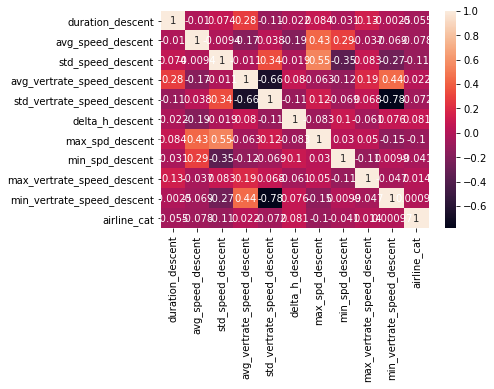

In [16]:
descent = ['duration_descent','avg_speed_descent','std_speed_descent','avg_vertrate_speed_descent','std_vertrate_speed_descent','delta_h_descent', 'max_spd_descent',
       'min_spd_descent', 'max_vertrate_speed_descent',
       'min_vertrate_speed_descent','airline_cat']
sns.heatmap(df_noairline[descent].corr(),annot = True)

<AxesSubplot:>

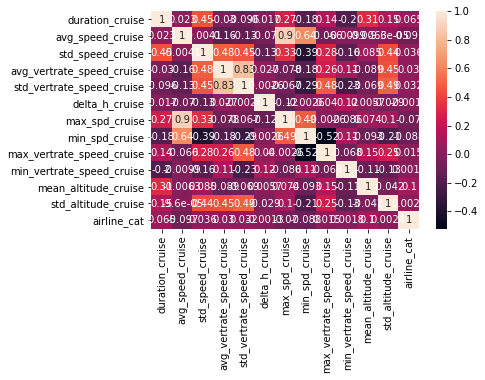

In [17]:
cruise = ['duration_cruise', 'avg_speed_cruise',
       'std_speed_cruise', 'avg_vertrate_speed_cruise',
       'std_vertrate_speed_cruise', 'delta_h_cruise', 'max_spd_cruise',
       'min_spd_cruise', 'max_vertrate_speed_cruise',
       'min_vertrate_speed_cruise', 'mean_altitude_cruise',
       'std_altitude_cruise','airline_cat']
sns.heatmap(df_noairline[cruise].corr(),annot = True)

<AxesSubplot:>

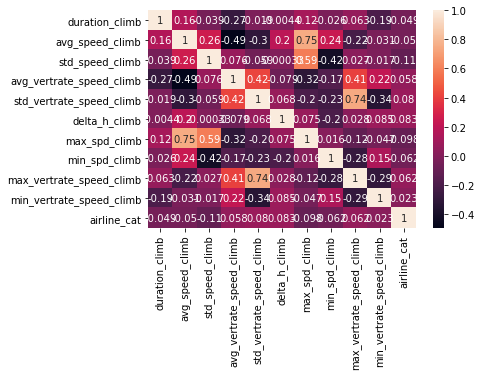

In [18]:
climb = ['duration_climb', 'avg_speed_climb',
       'std_speed_climb', 'avg_vertrate_speed_climb',
       'std_vertrate_speed_climb', 'delta_h_climb', 'max_spd_climb',
       'min_spd_climb', 'max_vertrate_speed_climb', 'min_vertrate_speed_climb',
       'airline_cat']
sns.heatmap(df_noairline[climb].corr(),annot = True)

In [19]:
corr_matrix = df_noairline.corr(method='spearman')

In [20]:
(corr_matrix[(corr_matrix>0.5) | (corr_matrix<-0.5)].count().sum() - corr_matrix.columns.shape[0])/2

37.0

There exists several couples (37) of variables that are highly correlated, with a coefficient of correlation superior to 0.5. A feature selection process needs to be conducted.

In [21]:
# Standard Scaling (not necessary for random forest)
X = df_filt_10log.iloc[:,:-1]
y = df_filt_10log.loc[:,["airline_cat"]]
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [22]:
# Spliting the data into train and test datasets


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Training a random forest classifier 
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)


/Users/z.wu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RandomForestClassifier(n_estimators=10000, n_jobs=-1, random_state=0)

In [23]:
# Print the name and gini importance of each feature
columns = df_filt_10log.columns
for feature in zip(columns, clf.feature_importances_):
    print(feature)

('flight_duration', 0.0414246887612151)
('duration_descent', 0.03445559171330998)
('avg_speed_descent', 0.02949673787239679)
('std_speed_descent', 0.031172277598213678)
('avg_vertrate_speed_descent', 0.035222605308581116)
('std_vertrate_speed_descent', 0.03337192166642727)
('delta_h_descent', 0.03436829777570008)
('max_spd_descent', 0.0280538891011951)
('min_spd_descent', 0.03495551642310457)
('max_vertrate_speed_descent', 0.01799158460835214)
('min_vertrate_speed_descent', 0.029416579394468186)
('duration_cruise', 0.03582164573661657)
('avg_speed_cruise', 0.03225865193065493)
('std_speed_cruise', 0.030463346818096218)
('avg_vertrate_speed_cruise', 0.02945574650257564)
('std_vertrate_speed_cruise', 0.02840173565766762)
('delta_h_cruise', 0.024430047617873752)
('max_spd_cruise', 0.03036154485568474)
('min_spd_cruise', 0.029889018356510404)
('max_vertrate_speed_cruise', 0.016919292434589558)
('min_vertrate_speed_cruise', 0.016476424758751485)
('mean_altitude_cruise', 0.03334186448397551)

In [24]:
len(clf.feature_importances_), len(columns)

(33, 34)

<BarContainer object of 33 artists>

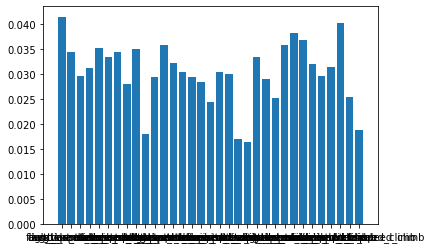

In [25]:
plt.bar(columns[:-1],clf.feature_importances_)

In [26]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.15

sfm = SelectFromModel(clf, threshold=0.025)

# Train the selector
sfm.fit(X_train, y_train)

/Users/z.wu/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_from_model.py:224: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


SelectFromModel(estimator=RandomForestClassifier(n_estimators=10000, n_jobs=-1,
                                                 random_state=0),
                threshold=0.025)

In [27]:
# Print the names of the most important features
i = 0
for feature_list_index in sfm.get_support(indices=True):
    print(columns[feature_list_index])
    i += 1
print(f'The number of columns chosen is {i}')

flight_duration
duration_descent
avg_speed_descent
std_speed_descent
avg_vertrate_speed_descent
std_vertrate_speed_descent
delta_h_descent
max_spd_descent
min_spd_descent
min_vertrate_speed_descent
duration_cruise
avg_speed_cruise
std_speed_cruise
avg_vertrate_speed_cruise
std_vertrate_speed_cruise
max_spd_cruise
min_spd_cruise
mean_altitude_cruise
std_altitude_cruise
duration_climb
avg_speed_climb
std_speed_climb
avg_vertrate_speed_climb
std_vertrate_speed_climb
delta_h_climb
max_spd_climb
min_spd_climb
max_vertrate_speed_climb
The number of columns chosen is 28


In [28]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [29]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

/Users/z.wu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(n_estimators=10000, n_jobs=-1, random_state=0)

In [30]:

# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
accuracy_score(y_test, y_pred)

0.33890214797136037

In [31]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
accuracy_score(y_test, y_important_pred)

0.3412887828162291

In [32]:
# Transform all data
selection = sfm.get_support()
X_columns = columns[:-1]
columns_remained = X_columns[selection]
X_new = sfm.transform(X)

# Aggregating data

In [33]:
X_new_df = pd.DataFrame(data = X_new, columns = columns_remained)
y.reset_index(inplace = True)

In [34]:
y.reset_index(inplace = True)

In [35]:
X_new_df.head()

,flight_duration,duration_descent,avg_speed_descent,std_speed_descent,avg_vertrate_speed_descent,std_vertrate_speed_descent,delta_h_descent,max_spd_descent,min_spd_descent,min_vertrate_speed_descent,...,std_altitude_cruise,duration_climb,avg_speed_climb,std_speed_climb,avg_vertrate_speed_climb,std_vertrate_speed_climb,delta_h_climb,max_spd_climb,min_spd_climb,max_vertrate_speed_climb
0,3950.0,1430.0,203.471221,62.125861,-10.575267,4.484652,-11788.14,260.709946,67.075291,-16.58112,...,8.014206,1310.0,205.831394,45.368032,8.503342,4.174381,11094.72,248.314504,84.257384,18.53184
1,2690.0,1430.0,145.137242,63.020736,-6.980326,3.924485,-9425.94,220.182633,60.110751,-13.32992,...,5.471136,830.0,175.686270,44.604026,11.266813,4.286211,9349.74,218.126683,76.168989,21.13280
2,3820.0,1300.0,191.382958,48.947396,-11.514930,5.329745,-11430.00,246.749245,71.290877,-21.13280,...,7.373829,1190.0,197.285841,45.290281,9.366412,4.056804,11407.14,235.792757,80.564296,20.48256
3,4430.0,1610.0,150.304353,53.973216,-7.697436,4.268665,-11452.86,220.635910,69.211362,-23.40864,...,6.949385,1190.0,175.026159,44.685534,10.420513,4.542592,11460.48,223.414447,70.989544,19.50720
4,3860.0,1290.0,166.982248,74.097079,-9.804174,7.294517,-9997.44,251.461574,58.657897,-21.45792,...,5.006471,820.0,180.356886,55.806234,11.613286,5.746633,9806.94,243.046889,72.244131,26.98496


In [36]:
new_df = pd.merge(X_new_df, y, how = 'left', left_index = True, right_on = 'index')

In [37]:
new_df.drop("index", axis = 1, inplace = True)

In [38]:
new_df

,flight_duration,duration_descent,avg_speed_descent,std_speed_descent,avg_vertrate_speed_descent,std_vertrate_speed_descent,delta_h_descent,max_spd_descent,min_spd_descent,min_vertrate_speed_descent,...,avg_speed_climb,std_speed_climb,avg_vertrate_speed_climb,std_vertrate_speed_climb,delta_h_climb,max_spd_climb,min_spd_climb,max_vertrate_speed_climb,flight_id,airline_cat
0,3950.0,1430.0,203.471221,62.125861,-10.575267,4.484652,-11788.14,260.709946,67.075291,-16.58112,...,205.831394,45.368032,8.503342,4.174381,11094.72,248.314504,84.257384,18.53184,8,13
1,2690.0,1430.0,145.137242,63.020736,-6.980326,3.924485,-9425.94,220.182633,60.110751,-13.32992,...,175.686270,44.604026,11.266813,4.286211,9349.74,218.126683,76.168989,21.13280,9,13
2,3820.0,1300.0,191.382958,48.947396,-11.514930,5.329745,-11430.00,246.749245,71.290877,-21.13280,...,197.285841,45.290281,9.366412,4.056804,11407.14,235.792757,80.564296,20.48256,10,13
3,4430.0,1610.0,150.304353,53.973216,-7.697436,4.268665,-11452.86,220.635910,69.211362,-23.40864,...,175.026159,44.685534,10.420513,4.542592,11460.48,223.414447,70.989544,19.50720,11,13
4,3860.0,1290.0,166.982248,74.097079,-9.804174,7.294517,-9997.44,251.461574,58.657897,-21.45792,...,180.356886,55.806234,11.613286,5.746633,9806.94,243.046889,72.244131,26.98496,12,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,9440.0,12830.0,125.724175,77.023196,-4.830792,3.519631,-99.06,272.300317,73.118040,-22.43328,...,207.860322,44.467902,6.338518,3.480896,8976.36,250.749631,90.635631,17.23136,1548,16
1390,10550.0,2030.0,164.236193,53.660873,-5.820395,2.338124,-10126.98,225.129652,76.139450,-11.37920,...,179.303870,31.210777,7.797506,3.768444,10180.32,209.901348,81.478900,17.88160,1549,16
1391,6230.0,2150.0,181.068509,54.288724,-5.017080,2.550111,-10866.12,251.221499,75.625018,-13.32992,...,210.485029,47.214662,6.732151,3.580889,10797.54,249.882138,84.368816,15.28064,1551,16
1392,3710.0,1730.0,155.604745,46.087774,-5.640215,2.538586,-9685.02,231.856778,52.475810,-13.00480,...,195.641094,40.385270,6.951612,3.072859,9784.08,236.175184,78.804022,13.32992,1552,16


This airline has 144 flights.


/Users/z.wu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


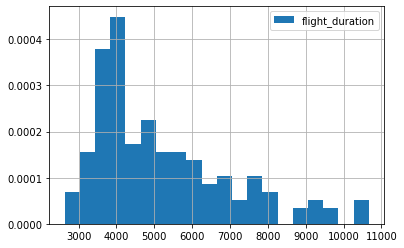

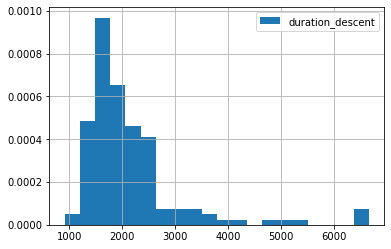

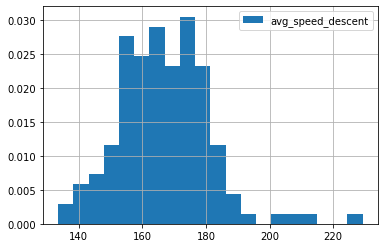

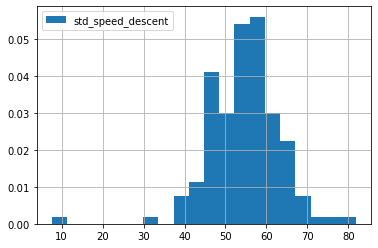

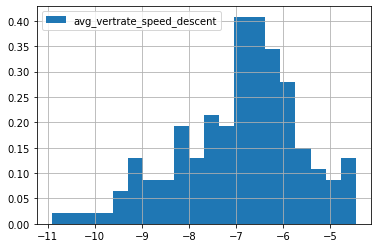

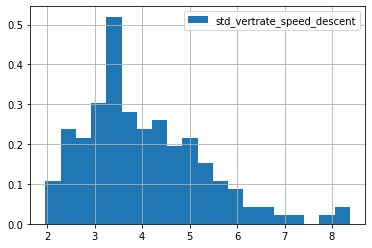

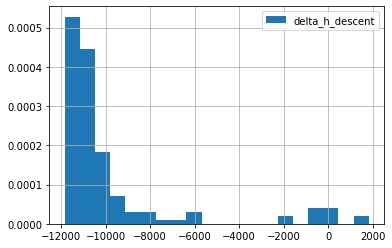

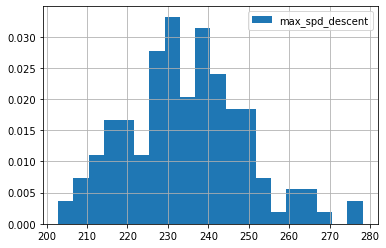

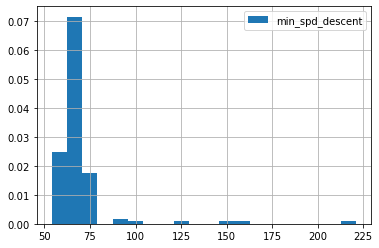

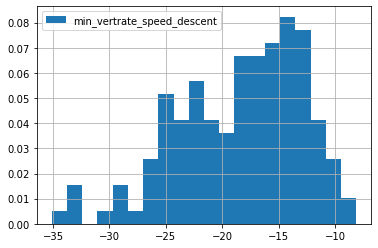

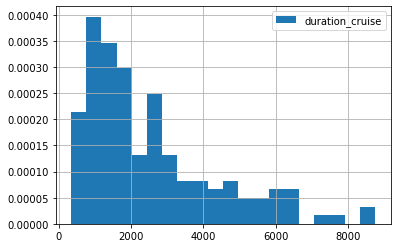

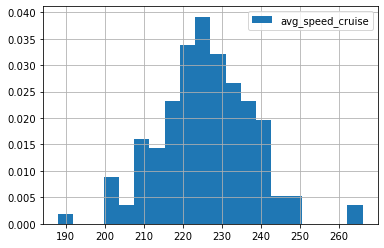

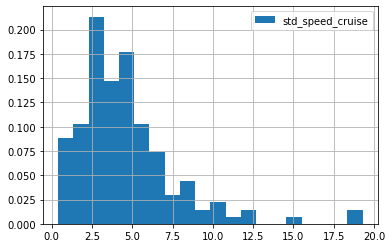

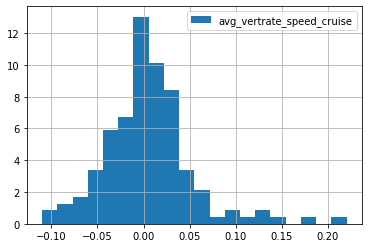

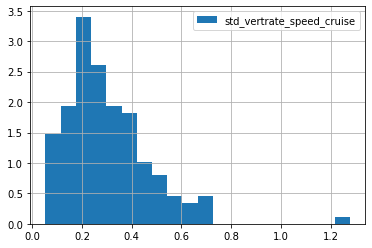

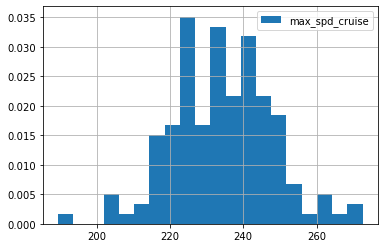

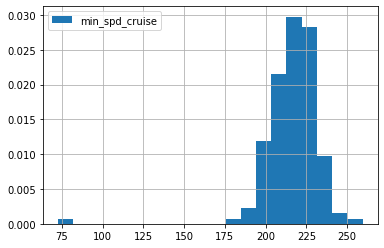

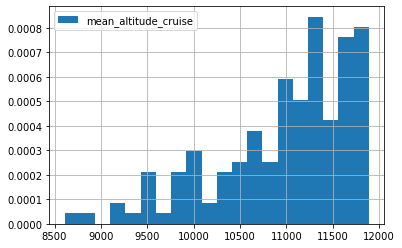

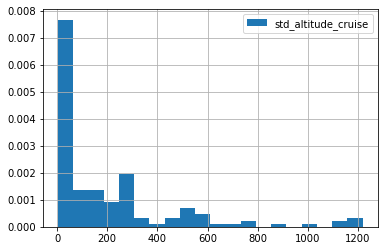

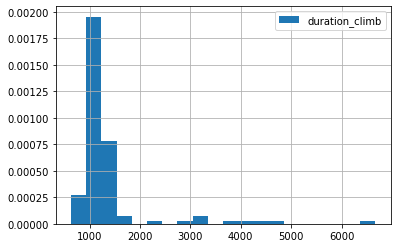

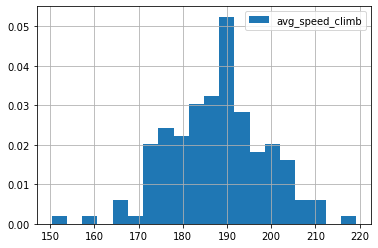

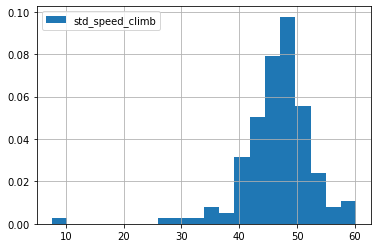

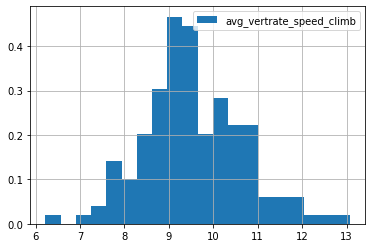

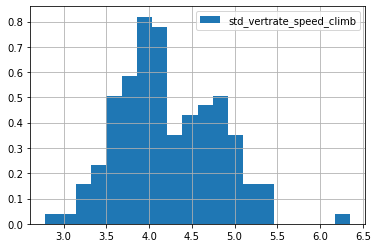

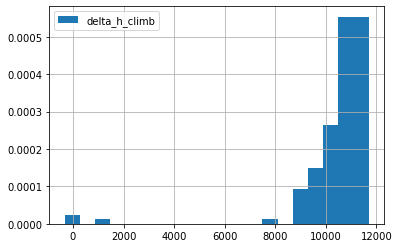

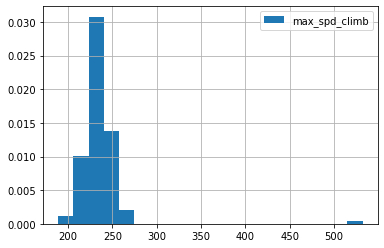

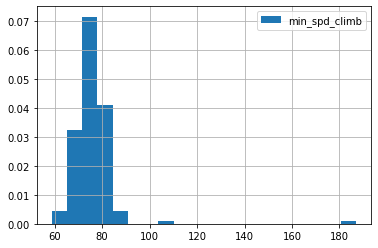

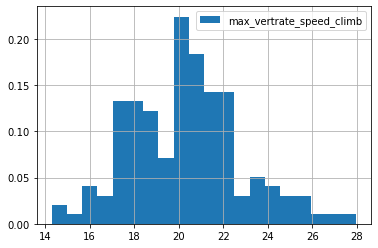

In [39]:
# Check the distribution of features for a specific airline
airline_cat = 5
nb = new_df[new_df['airline_cat'] == airline_cat].shape[0]
print(f'This airline has {nb} flights.')
for i in range(0,X_new_df.shape[1],1):
    plt.figure()
    new_df[new_df['airline_cat'] == airline_cat].iloc[:,i].hist(bins =20, label = new_df.columns[i], density = True)
    plt.legend()

In [40]:
df_median = new_df.groupby(by = 'airline_cat').median()

In [41]:
df_median.drop("flight_id", axis = 1, inplace=True)

In [51]:
from sklearn.preprocessing import RobustScaler
df_median_values = df_median.values
scaler = RobustScaler().fit(df_median_values)
df_median_scaled = scaler.fit_transform(df_median_values)
df_median_scaled = pd.DataFrame(df_median_scaled)

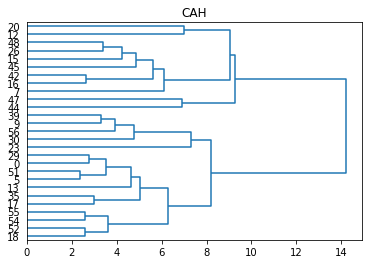

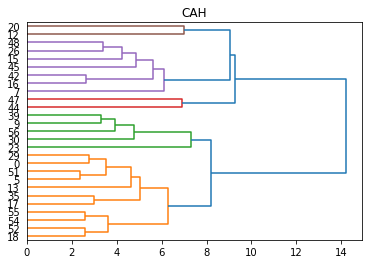

In [53]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(df_median_scaled,method='ward',metric='euclidean')
plt.title("CAH")
dendrogram(Z,labels=df_median.index,orientation='right',color_threshold=0)
plt.show()
plt.title('CAH')
dendrogram(Z,labels=df_median.index,orientation='right',color_threshold=8)
plt.show()

In [55]:
import numpy as np
import pandas
groupes_cah = fcluster(Z,t=8,criterion='distance')
print(groupes_cah)

[1 1 4 2 5 1 4 4 1 1 5 2 4 1 2 1 2 4 3 4 3 4 1 1 1 1 2]


In [56]:
idg = np.argsort(groupes_cah)
df1 = pandas.DataFrame(df_median.index[idg],groupes_cah[idg])
df2 = pd.DataFrame.from_dict(airlines_decoder, orient='index')

In [57]:
pd.merge(df1, df2, how = 'left', left_on = 'airline_cat', right_index = True)

,airline_cat,0
1,0,Aer Lingus
1,54,easyJet Europe
1,52,Wizz Air
1,51,Vueling Airlines
1,35,Lufthansa
1,55,easyJet Switzerland
1,18,British Airways
1,17,Austrian Airlines
1,29,Eurowings
1,5,Air France
